Simulator: SMA
==============

This script simulates `Interferometer` data of a strong lens where:

 - The resolution, UV wavelengths and S/N are representative of Square Mile Array (SMA) interferometry.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset Paths__

The `dataset_type` describes the type of data being simulated (in this case, `Imaging` data) and `dataset_name` 
gives it a descriptive name. They define the folder the dataset is output to on your hard-disk:

 - The image will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/image.fits`.
 - The noise-map will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/noise_map.fits`.
 - The psf will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/psf.fits`.

In [2]:
dataset_type = "instruments"
dataset_instrument = "sma"

The path where the dataset will be output, which in this case is
`/autolens_workspace/dataset/interferometer/instruments/sma/mass_sie__source_sersic`

In [3]:
dataset_path = path.join("dataset", "interferometer", dataset_type, dataset_instrument)

__Simulate__

For simulating an image of a strong lens, we recommend using a Grid2DIterate object. This represents a grid of (y,x) 
coordinates like an ordinary Grid2D, but when the light-profile`s image is evaluated below (using the Tracer) the 
sub-size of the grid is iteratively increased (in steps of 2, 4, 8, 16, 24) until the input fractional accuracy of 
99.99% is met.

This ensures that the divergent and bright central regions of the source galaxy are fully resolved when determining the
total flux emitted within a pixel.

In [4]:
grid = al.Grid2DIterate.uniform(
    shape_native=(251, 251), pixel_scales=0.05, fractional_accuracy=0.9999
)

To perform the Fourier transform we need the wavelengths of the baselines, which we'll load from the fits file below.

By default we use baselines from the Square Mile Array (SMA), which produces low resolution interferometer data that
can be fitted extremely efficiently. The `autolens_workspace` includes ALMA uv_wavelengths files for simulating
much high resolution datasets (which can be performed by replacing "sma.fits" below with "alma.fits").

In [5]:
uv_wavelengths_path = path.join("dataset", "interferometer", "uv_wavelengths")
uv_wavelengths = al.util.array_1d.numpy_array_1d_from_fits(
    file_path=path.join(uv_wavelengths_path, "sma.fits"), hdu=0
)

To simulate the interferometer dataset we first create a simulator, which defines the shape, resolution and pixel-scale 
of the visibilities that are simulated, as well as its exposure time, noise levels and uv-wavelengths.

In [6]:
simulator = al.SimulatorInterferometer(
    uv_wavelengths=uv_wavelengths,
    exposure_time=100.0,
    background_sky_level=0.1,
    noise_sigma=100.0,
    transformer_class=al.TransformerDFT,
)

__Ray Tracing__

Setup the lens galaxy's mass (SIE+Shear) and source galaxy light (elliptical Sersic) for this simulated lens.

In [7]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(-0.3, -0.3),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=3.0,
    ),
)

Use these galaxies to setup a tracer, which will generate the image for the simulated `Imaging` dataset.

In [8]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Lets look at the tracer`s image, this is the image we'll be simulating.

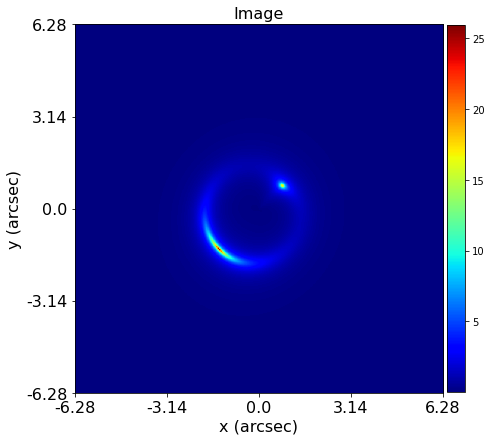

In [9]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)

We can now pass this simulator a tracer, which creates the ray-traced image plotted above and simulates it as an
interferometer dataset.

In [10]:
interferometer = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

Lets plot the simulated interferometer dataset before we output it to fits.

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoArray/autoarray/plot/mat_wrap/mat_plot.py:178: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows, columns, self.subplot_index)


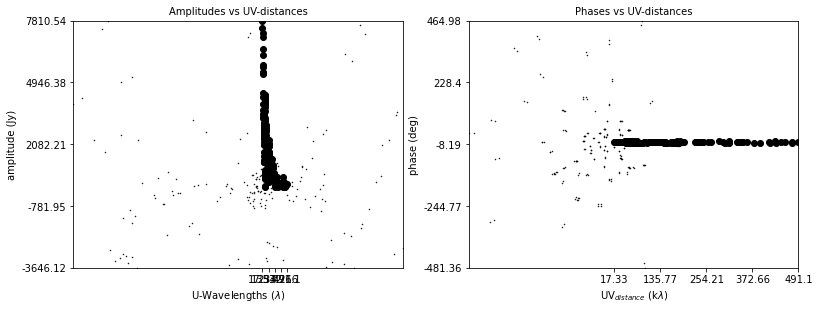

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/pynufft/linalg/nufft_cpu.py:381: ComplexWarning: Casting complex values to real discards the imaginary part
  xx.ravel()[self.NdCPUorder * self.batch + bat] = k.ravel()[
/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/pynufft/linalg/nufft_cpu.py:381: ComplexWarning: Casting complex values to real discards the imaginary part
  xx.ravel()[self.NdCPUorder * self.batch + bat] = k.ravel()[


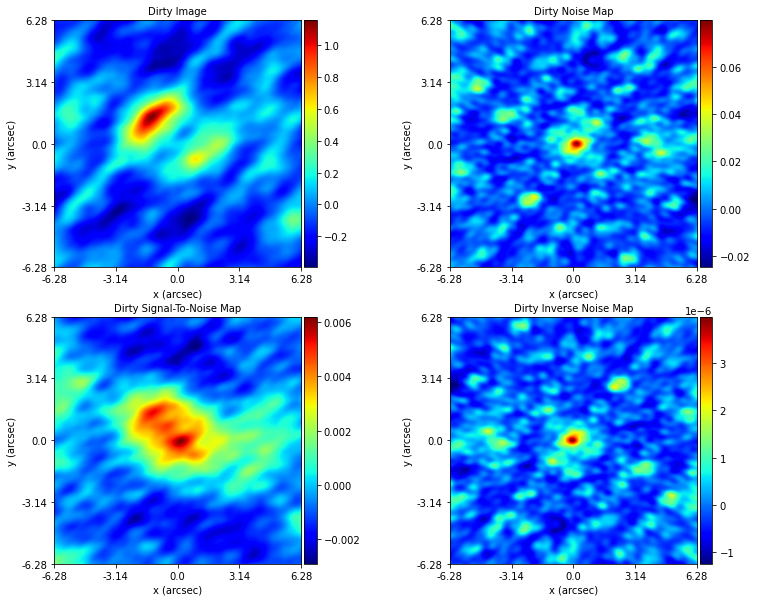

In [11]:
interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

__Output__

Output the simulated dataset to the dataset path as .fits files.

In [12]:
interferometer.output_to_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    overwrite=True,
)

Output a subplot of the simulated dataset, the image and a subplot of the `Tracer`'s quantities to the dataset path 
as .png files.

In [13]:
mat_plot_2d = aplt.MatPlot2D(output=aplt.Output(path=dataset_path, format="png"))

interferometer_plotter = aplt.InterferometerPlotter(
    interferometer=interferometer, mat_plot_2d=mat_plot_2d
)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.subplot_tracer()

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoArray/autoarray/plot/mat_wrap/mat_plot.py:178: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows, columns, self.subplot_index)


Pickle the `Tracer` in the dataset folder, ensuring the true `Tracer` is safely stored and available if we need to 
check how the dataset was simulated in the future. 

This will also be accessible via the `Aggregator` if a model-fit is performed using the dataset.

In [14]:
tracer.save(file_path=dataset_path, filename="true_tracer")

The dataset can be viewed in the folder `autolens_workspace/interferometer/instruments/sma`.